# Part 2: Modelling and Financial Analysis

In [1]:
# Importing necessary libraries

import numpy as np  # Linear algebra
import pandas as pd  # Data manipulation
import matplotlib.pyplot as plt  # Visualization 
import seaborn as sns # Visualization

## Building the XGBoost Classifier model

First, let's import our prepared data for training and testing.

In [2]:
import pickle

with open('train_test.pkl', 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

We will now build a baseline XGBoost Classifier model for different number of estimators (trees), just to see the general behavior of the model (especially, whether it overfits or not). 

To evaluate the model, we will use both the ROC AUC as well as the regular Accuracy Score.

In [28]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

# Store ROC AUC and Accuracy scores
roc_auc_list = []
accuracy_list = []

# Number of trees to build the model
n_trees = [50,100,200,300,400,500,600,700,800,900,1000,1250,1500,2000]

for n_estimators in n_trees:
    
    # baseline model
    xgb = XGBClassifier(
    learning_rate=0.1,
    verbosity=1,
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    n_jobs=-1,
    n_estimators=n_estimators)
    
    # fitting the model on the train data
    xgb.fit(X_train, y_train)
    
    # Get predicted probabilities and predictions on the test data
    predictions_proba = xgb.predict_proba(X_test)[:,1]
    predictions = xgb.predict(X_test)
    
    # Get accuracy scores
    roc_auc_list.append(roc_auc_score(y_test, predictions_proba))
    accuracy_list.append(accuracy_score(y_test, predictions))

In [57]:
df_scores = pd.DataFrame(index=n_trees, data={'accuracy':accuracy_list, 'ROC AUC':roc_auc_list})
df_scores

,accuracy,roc_auc_list
50,0.820500,0.782280
100,0.820500,0.781870
200,0.817333,0.776837
300,0.816000,0.774747
400,0.815500,0.772004
500,0.815167,0.769880
600,0.815500,0.767646
700,0.813833,0.766214
800,0.812500,0.764325
900,0.812333,0.762922


<Figure size 1080x1080 with 0 Axes>

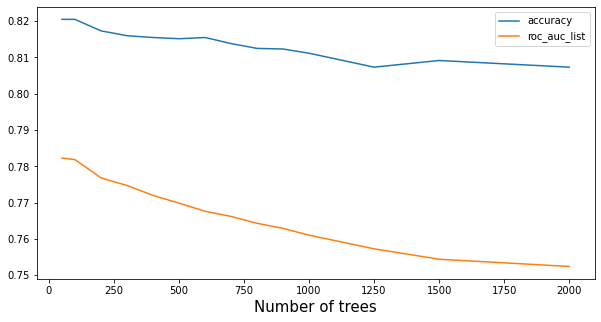

In [56]:
plt.figure(figsize=(15,15))
df_scores.plot(figsize=(10,5))
plt.xlabel('Number of trees', fontsize=15);

As we can see, the best scores for both accuracy and roc auc are attained when the number of trees is not greater than 100. 

To ensure that our model actually performs well on unseen, new data, we will use Grid Search Cross Validation. 

In [5]:
from sklearn.model_selection import GridSearchCV

In [6]:
param_grid = {'n_estimators': [50,60,70,80,90,100],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [2,3,4,5,6,7,8], 
              'min_child_weight': [0, 1, 2],
              'gamma': [0, 0.5, 1, 1.5]}

Keep in mind that this grid is quite large, and consequently it's going to take a lot of time to finish. Just to have an idea, let's calculate the amount of combinations that GridSearchCV has to go through.

In [65]:
# lenght of every list of parameters
lst = [len(x) for x in param_grid.values()]
lst

[6, 3, 7, 3, 4]

In [66]:
# combinations
np.prod(lst)

1512

Thus, there are 1512 combinations. And remember also that CV has to go through different splits through 5 folds. We will be cautious and will only perform CV one time.

In [7]:
# baseline model
xgb = XGBClassifier(objective='binary:logistic', 
                    eval_metric='auc', 
                    n_jobs=-1, 
                    use_label_encoder=False)

# setting up GridSearchCV
grid_model = GridSearchCV(xgb, param_grid, scoring='roc_auc', verbose=2)

In [9]:
# fitting GridSearchCV on the train data
# DO NOT RUN THIS CELL UNNECESSARILY
%%time

grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 1512 candidates, totalling 7560 fits
[CV] END gamma=0, learning_rate=0.1, max_depth=2, min_child_weight=0, n_estimators=50; total time=   0.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=2, min_child_weight=0, n_estimators=50; total time=   0.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=2, min_child_weight=0, n_estimators=50; total time=   0.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=2, min_child_weight=0, n_estimators=50; total time=   0.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=2, min_child_weight=0, n_estimators=50; total time=   0.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=2, min_child_weight=0, n_estimators=60; total time=   0.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=2, min_child_weight=0, n_estimators=60; total time=   0.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=2, min_child_weight=0, n_estimators=60; total time=   0.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=2, min_child_weight=0, n_estimators=60; 

[CV] END gamma=0, learning_rate=0.1, max_depth=2, min_child_weight=2, n_estimators=80; total time=   0.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=2, min_child_weight=2, n_estimators=80; total time=   0.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=2, min_child_weight=2, n_estimators=80; total time=   0.2s
[CV] END gamma=0, learning_rate=0.1, max_depth=2, min_child_weight=2, n_estimators=90; total time=   0.3s
[CV] END gamma=0, learning_rate=0.1, max_depth=2, min_child_weight=2, n_estimators=90; total time=   0.2s
[CV] END gamma=0, learning_rate=0.1, max_depth=2, min_child_weight=2, n_estimators=90; total time=   0.2s
[CV] END gamma=0, learning_rate=0.1, max_depth=2, min_child_weight=2, n_estimators=90; total time=   0.2s
[CV] END gamma=0, learning_rate=0.1, max_depth=2, min_child_weight=2, n_estimators=90; total time=   0.2s
[CV] END gamma=0, learning_rate=0.1, max_depth=2, min_child_weight=2, n_estimators=100; total time=   0.2s
[CV] END gamma=0, learning_rate=0.1, max_dept

[CV] END gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=60; total time=   0.2s
[CV] END gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=60; total time=   0.2s
[CV] END gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=60; total time=   0.2s
[CV] END gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=60; total time=   0.2s
[CV] END gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=60; total time=   0.2s
[CV] END gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=70; total time=   0.2s
[CV] END gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=70; total time=   0.2s
[CV] END gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=70; total time=   0.2s
[CV] END gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=70; total time=   0.2s
[CV] END gamma=0, learning_rate=0.1, max_depth

[CV] END gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=90; total time=   0.4s
[CV] END gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=90; total time=   0.4s
[CV] END gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=100; total time=   0.4s
[CV] END gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=100; total time=   0.4s
[CV] END gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=100; total time=   0.5s
[CV] END gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=100; total time=   0.4s
[CV] END gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=100; total time=   0.5s
[CV] END gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=50; total time=   0.2s
[CV] END gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=50; total time=   0.3s
[CV] END gamma=0, learning_rate=0.1, max_

[CV] END gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=70; total time=   0.4s
[CV] END gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=70; total time=   0.4s
[CV] END gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=70; total time=   0.4s
[CV] END gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=70; total time=   0.4s
[CV] END gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=80; total time=   0.5s
[CV] END gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=80; total time=   0.5s
[CV] END gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=80; total time=   0.4s
[CV] END gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=80; total time=   0.5s
[CV] END gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=80; total time=   0.5s
[CV] END gamma=0, learning_rate=0.1, max_depth

[CV] END gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=0, n_estimators=100; total time=   0.8s
[CV] END gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=50; total time=   0.4s
[CV] END gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=50; total time=   0.4s
[CV] END gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=50; total time=   0.3s
[CV] END gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=50; total time=   0.4s
[CV] END gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=50; total time=   0.3s
[CV] END gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=60; total time=   0.4s
[CV] END gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=60; total time=   0.4s
[CV] END gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=60; total time=   0.4s
[CV] END gamma=0, learning_rate=0.1, max_dept

[CV] END gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=0, n_estimators=80; total time=   0.7s
[CV] END gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=0, n_estimators=80; total time=   0.8s
[CV] END gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=0, n_estimators=80; total time=   0.9s
[CV] END gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=0, n_estimators=90; total time=   0.9s
[CV] END gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=0, n_estimators=90; total time=   0.9s
[CV] END gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=0, n_estimators=90; total time=   0.8s
[CV] END gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=0, n_estimators=90; total time=   1.0s
[CV] END gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=0, n_estimators=90; total time=   1.0s
[CV] END gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=0, n_estimators=100; total time=   0.9s
[CV] END gamma=0, learning_rate=0.1, max_dept

[CV] END gamma=0, learning_rate=0.1, max_depth=8, min_child_weight=0, n_estimators=60; total time=   0.8s
[CV] END gamma=0, learning_rate=0.1, max_depth=8, min_child_weight=0, n_estimators=60; total time=   0.8s
[CV] END gamma=0, learning_rate=0.1, max_depth=8, min_child_weight=0, n_estimators=60; total time=   0.8s
[CV] END gamma=0, learning_rate=0.1, max_depth=8, min_child_weight=0, n_estimators=60; total time=   0.7s
[CV] END gamma=0, learning_rate=0.1, max_depth=8, min_child_weight=0, n_estimators=60; total time=   0.7s
[CV] END gamma=0, learning_rate=0.1, max_depth=8, min_child_weight=0, n_estimators=70; total time=   0.8s
[CV] END gamma=0, learning_rate=0.1, max_depth=8, min_child_weight=0, n_estimators=70; total time=   1.0s
[CV] END gamma=0, learning_rate=0.1, max_depth=8, min_child_weight=0, n_estimators=70; total time=   0.9s
[CV] END gamma=0, learning_rate=0.1, max_depth=8, min_child_weight=0, n_estimators=70; total time=   1.0s
[CV] END gamma=0, learning_rate=0.1, max_depth

[CV] END gamma=0, learning_rate=0.1, max_depth=8, min_child_weight=2, n_estimators=90; total time=   1.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=8, min_child_weight=2, n_estimators=90; total time=   1.0s
[CV] END gamma=0, learning_rate=0.1, max_depth=8, min_child_weight=2, n_estimators=100; total time=   1.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=8, min_child_weight=2, n_estimators=100; total time=   1.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=8, min_child_weight=2, n_estimators=100; total time=   1.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=8, min_child_weight=2, n_estimators=100; total time=   1.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=8, min_child_weight=2, n_estimators=100; total time=   1.1s
[CV] END gamma=0, learning_rate=0.05, max_depth=2, min_child_weight=0, n_estimators=50; total time=   0.1s
[CV] END gamma=0, learning_rate=0.05, max_depth=2, min_child_weight=0, n_estimators=50; total time=   0.1s
[CV] END gamma=0, learning_rate=0.05, m

[CV] END gamma=0, learning_rate=0.05, max_depth=2, min_child_weight=2, n_estimators=70; total time=   0.1s
[CV] END gamma=0, learning_rate=0.05, max_depth=2, min_child_weight=2, n_estimators=70; total time=   0.1s
[CV] END gamma=0, learning_rate=0.05, max_depth=2, min_child_weight=2, n_estimators=70; total time=   0.1s
[CV] END gamma=0, learning_rate=0.05, max_depth=2, min_child_weight=2, n_estimators=70; total time=   0.1s
[CV] END gamma=0, learning_rate=0.05, max_depth=2, min_child_weight=2, n_estimators=70; total time=   0.1s
[CV] END gamma=0, learning_rate=0.05, max_depth=2, min_child_weight=2, n_estimators=80; total time=   0.2s
[CV] END gamma=0, learning_rate=0.05, max_depth=2, min_child_weight=2, n_estimators=80; total time=   0.2s
[CV] END gamma=0, learning_rate=0.05, max_depth=2, min_child_weight=2, n_estimators=80; total time=   0.2s
[CV] END gamma=0, learning_rate=0.05, max_depth=2, min_child_weight=2, n_estimators=80; total time=   0.2s
[CV] END gamma=0, learning_rate=0.05,

[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100; total time=   0.3s
[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100; total time=   0.4s
[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100; total time=   0.4s
[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=2, n_estimators=50; total time=   0.2s
[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=2, n_estimators=50; total time=   0.2s
[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=2, n_estimators=50; total time=   0.2s
[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=2, n_estimators=50; total time=   0.2s
[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=2, n_estimators=50; total time=   0.2s
[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=2, n_estimators=60; total time=   0.2s
[CV] END gamma=0, learning_rate=0.

[CV] END gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=70; total time=   0.3s
[CV] END gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=80; total time=   0.3s
[CV] END gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=80; total time=   0.4s
[CV] END gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=80; total time=   0.4s
[CV] END gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=80; total time=   0.4s
[CV] END gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=80; total time=   0.3s
[CV] END gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=90; total time=   0.4s
[CV] END gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=90; total time=   0.4s
[CV] END gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=90; total time=   0.4s
[CV] END gamma=0, learning_rate=0.05,

[CV] END gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=50; total time=   0.3s
[CV] END gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=50; total time=   0.3s
[CV] END gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=50; total time=   0.3s
[CV] END gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=50; total time=   0.3s
[CV] END gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=60; total time=   0.4s
[CV] END gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=60; total time=   0.3s
[CV] END gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=60; total time=   0.3s
[CV] END gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=60; total time=   0.4s
[CV] END gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=60; total time=   0.4s
[CV] END gamma=0, learning_rate=0.05,

[CV] END gamma=0, learning_rate=0.05, max_depth=6, min_child_weight=0, n_estimators=80; total time=   0.7s
[CV] END gamma=0, learning_rate=0.05, max_depth=6, min_child_weight=0, n_estimators=80; total time=   0.7s
[CV] END gamma=0, learning_rate=0.05, max_depth=6, min_child_weight=0, n_estimators=90; total time=   0.8s
[CV] END gamma=0, learning_rate=0.05, max_depth=6, min_child_weight=0, n_estimators=90; total time=   0.7s
[CV] END gamma=0, learning_rate=0.05, max_depth=6, min_child_weight=0, n_estimators=90; total time=   0.8s
[CV] END gamma=0, learning_rate=0.05, max_depth=6, min_child_weight=0, n_estimators=90; total time=   0.8s
[CV] END gamma=0, learning_rate=0.05, max_depth=6, min_child_weight=0, n_estimators=90; total time=   0.7s
[CV] END gamma=0, learning_rate=0.05, max_depth=6, min_child_weight=0, n_estimators=100; total time=   0.8s
[CV] END gamma=0, learning_rate=0.05, max_depth=6, min_child_weight=0, n_estimators=100; total time=   0.8s
[CV] END gamma=0, learning_rate=0.0

[CV] END gamma=0, learning_rate=0.05, max_depth=7, min_child_weight=0, n_estimators=60; total time=   0.6s
[CV] END gamma=0, learning_rate=0.05, max_depth=7, min_child_weight=0, n_estimators=60; total time=   0.6s
[CV] END gamma=0, learning_rate=0.05, max_depth=7, min_child_weight=0, n_estimators=60; total time=   0.6s
[CV] END gamma=0, learning_rate=0.05, max_depth=7, min_child_weight=0, n_estimators=60; total time=   0.6s
[CV] END gamma=0, learning_rate=0.05, max_depth=7, min_child_weight=0, n_estimators=60; total time=   0.6s
[CV] END gamma=0, learning_rate=0.05, max_depth=7, min_child_weight=0, n_estimators=70; total time=   0.7s
[CV] END gamma=0, learning_rate=0.05, max_depth=7, min_child_weight=0, n_estimators=70; total time=   0.7s
[CV] END gamma=0, learning_rate=0.05, max_depth=7, min_child_weight=0, n_estimators=70; total time=   0.7s
[CV] END gamma=0, learning_rate=0.05, max_depth=7, min_child_weight=0, n_estimators=70; total time=   0.7s
[CV] END gamma=0, learning_rate=0.05,

[CV] END gamma=0, learning_rate=0.05, max_depth=7, min_child_weight=2, n_estimators=90; total time=   0.9s
[CV] END gamma=0, learning_rate=0.05, max_depth=7, min_child_weight=2, n_estimators=90; total time=   0.9s
[CV] END gamma=0, learning_rate=0.05, max_depth=7, min_child_weight=2, n_estimators=90; total time=   0.9s
[CV] END gamma=0, learning_rate=0.05, max_depth=7, min_child_weight=2, n_estimators=100; total time=   1.0s
[CV] END gamma=0, learning_rate=0.05, max_depth=7, min_child_weight=2, n_estimators=100; total time=   0.9s
[CV] END gamma=0, learning_rate=0.05, max_depth=7, min_child_weight=2, n_estimators=100; total time=   1.0s
[CV] END gamma=0, learning_rate=0.05, max_depth=7, min_child_weight=2, n_estimators=100; total time=   1.0s
[CV] END gamma=0, learning_rate=0.05, max_depth=7, min_child_weight=2, n_estimators=100; total time=   1.0s
[CV] END gamma=0, learning_rate=0.05, max_depth=8, min_child_weight=0, n_estimators=50; total time=   0.6s
[CV] END gamma=0, learning_rate=

[CV] END gamma=0, learning_rate=0.05, max_depth=8, min_child_weight=2, n_estimators=60; total time=   0.7s
[CV] END gamma=0, learning_rate=0.05, max_depth=8, min_child_weight=2, n_estimators=70; total time=   0.8s
[CV] END gamma=0, learning_rate=0.05, max_depth=8, min_child_weight=2, n_estimators=70; total time=   0.9s
[CV] END gamma=0, learning_rate=0.05, max_depth=8, min_child_weight=2, n_estimators=70; total time=   0.8s
[CV] END gamma=0, learning_rate=0.05, max_depth=8, min_child_weight=2, n_estimators=70; total time=   0.8s
[CV] END gamma=0, learning_rate=0.05, max_depth=8, min_child_weight=2, n_estimators=70; total time=   0.8s
[CV] END gamma=0, learning_rate=0.05, max_depth=8, min_child_weight=2, n_estimators=80; total time=   0.9s
[CV] END gamma=0, learning_rate=0.05, max_depth=8, min_child_weight=2, n_estimators=80; total time=   0.9s
[CV] END gamma=0, learning_rate=0.05, max_depth=8, min_child_weight=2, n_estimators=80; total time=   0.9s
[CV] END gamma=0, learning_rate=0.05,

[CV] END gamma=0, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=100; total time=   0.2s
[CV] END gamma=0, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=100; total time=   0.2s
[CV] END gamma=0, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=100; total time=   0.2s
[CV] END gamma=0, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=100; total time=   0.2s
[CV] END gamma=0, learning_rate=0.01, max_depth=2, min_child_weight=2, n_estimators=50; total time=   0.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=2, min_child_weight=2, n_estimators=50; total time=   0.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=2, min_child_weight=2, n_estimators=50; total time=   0.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=2, min_child_weight=2, n_estimators=50; total time=   0.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=2, min_child_weight=2, n_estimators=50; total time=   0.1s
[CV] END gamma=0, learning_rate=0

[CV] END gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=70; total time=   0.2s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=70; total time=   0.2s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=80; total time=   0.2s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=80; total time=   0.2s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=80; total time=   0.2s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=80; total time=   0.2s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=80; total time=   0.2s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=90; total time=   0.3s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=90; total time=   0.3s
[CV] END gamma=0, learning_rate=0.01,

[CV] END gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=50; total time=   0.2s
[CV] END gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=50; total time=   0.2s
[CV] END gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=50; total time=   0.2s
[CV] END gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=50; total time=   0.2s
[CV] END gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=50; total time=   0.2s
[CV] END gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=60; total time=   0.2s
[CV] END gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=60; total time=   0.2s
[CV] END gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=60; total time=   0.2s
[CV] END gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=60; total time=   0.3s
[CV] END gamma=0, learning_rate=0.01,

[CV] END gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, n_estimators=80; total time=   0.5s
[CV] END gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, n_estimators=80; total time=   0.5s
[CV] END gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, n_estimators=80; total time=   0.5s
[CV] END gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, n_estimators=90; total time=   0.5s
[CV] END gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, n_estimators=90; total time=   0.5s
[CV] END gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, n_estimators=90; total time=   0.5s
[CV] END gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, n_estimators=90; total time=   0.5s
[CV] END gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, n_estimators=90; total time=   0.5s
[CV] END gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=0, n_estimators=100; total time=   0.6s
[CV] END gamma=0, learning_rate=0.01

[CV] END gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=0, n_estimators=50; total time=   0.3s
[CV] END gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=0, n_estimators=60; total time=   0.4s
[CV] END gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=0, n_estimators=60; total time=   0.4s
[CV] END gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=0, n_estimators=60; total time=   0.4s
[CV] END gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=0, n_estimators=60; total time=   0.4s
[CV] END gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=0, n_estimators=60; total time=   0.4s
[CV] END gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=0, n_estimators=70; total time=   0.6s
[CV] END gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=0, n_estimators=70; total time=   0.6s
[CV] END gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=0, n_estimators=70; total time=   0.5s
[CV] END gamma=0, learning_rate=0.01,

[CV] END gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=90; total time=   0.7s
[CV] END gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=90; total time=   0.7s
[CV] END gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=90; total time=   0.8s
[CV] END gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=90; total time=   0.7s
[CV] END gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=100; total time=   0.8s
[CV] END gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=100; total time=   0.7s
[CV] END gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=100; total time=   0.8s
[CV] END gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=100; total time=   0.8s
[CV] END gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=100; total time=   0.8s
[CV] END gamma=0, learning_rate=

[CV] END gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=60; total time=   0.5s
[CV] END gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=60; total time=   0.5s
[CV] END gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=70; total time=   0.7s
[CV] END gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=70; total time=   0.7s
[CV] END gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=70; total time=   0.6s
[CV] END gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=70; total time=   0.6s
[CV] END gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=70; total time=   0.7s
[CV] END gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=80; total time=   0.8s
[CV] END gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=80; total time=   0.7s
[CV] END gamma=0, learning_rate=0.01,

[CV] END gamma=0, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=100; total time=   1.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=100; total time=   1.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=100; total time=   1.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=100; total time=   1.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=100; total time=   1.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=8, min_child_weight=2, n_estimators=50; total time=   0.5s
[CV] END gamma=0, learning_rate=0.01, max_depth=8, min_child_weight=2, n_estimators=50; total time=   0.5s
[CV] END gamma=0, learning_rate=0.01, max_depth=8, min_child_weight=2, n_estimators=50; total time=   0.5s
[CV] END gamma=0, learning_rate=0.01, max_depth=8, min_child_weight=2, n_estimators=50; total time=   0.5s
[CV] END gamma=0, learning_rate=

[CV] END gamma=0.5, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=70; total time=   0.1s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=70; total time=   0.1s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=80; total time=   0.1s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=80; total time=   0.1s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=80; total time=   0.1s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=80; total time=   0.1s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=80; total time=   0.1s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=90; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=90; total time=   0.2s
[CV] END gamma=0.5, learning

[CV] END gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0, n_estimators=100; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=50; total time=   0.1s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=50; total time=   0.1s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=50; total time=   0.1s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=50; total time=   0.1s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=50; total time=   0.1s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=60; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=60; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=60; total time=   0.2s
[CV] END gamma=0.5, learnin

[CV] END gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=0, n_estimators=80; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=0, n_estimators=80; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=0, n_estimators=80; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=0, n_estimators=80; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=0, n_estimators=80; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=0, n_estimators=90; total time=   0.4s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=0, n_estimators=90; total time=   0.4s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=0, n_estimators=90; total time=   0.4s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=0, n_estimators=90; total time=   0.4s
[CV] END gamma=0.5, learning

[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=0, n_estimators=50; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=0, n_estimators=50; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=0, n_estimators=50; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=0, n_estimators=50; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=0, n_estimators=60; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=0, n_estimators=60; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=0, n_estimators=60; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=0, n_estimators=60; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=0, n_estimators=60; total time=   0.3s
[CV] END gamma=0.5, learning

[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=80; total time=   0.4s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=80; total time=   0.4s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=80; total time=   0.4s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=90; total time=   0.5s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=90; total time=   0.5s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=90; total time=   0.5s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=90; total time=   0.6s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=90; total time=   0.5s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=100; total time=   0.6s
[CV] END gamma=0.5, learnin

[CV] END gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=50; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=50; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=60; total time=   0.4s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=60; total time=   0.4s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=60; total time=   0.4s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=60; total time=   0.4s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=60; total time=   0.4s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=70; total time=   0.5s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=70; total time=   0.5s
[CV] END gamma=0.5, learning

[CV] END gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=80; total time=   0.7s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=90; total time=   0.8s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=90; total time=   0.9s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=90; total time=   0.8s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=90; total time=   0.7s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=90; total time=   0.8s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100; total time=   0.9s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100; total time=   0.8s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100; total time=   0.9s
[CV] END gamma=0.5, learn

[CV] END gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=60; total time=   0.6s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=60; total time=   0.6s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=60; total time=   0.6s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=60; total time=   0.6s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=60; total time=   0.6s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=70; total time=   0.7s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=70; total time=   0.8s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=70; total time=   0.7s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=70; total time=   0.7s
[CV] END gamma=0.5, learning

[CV] END gamma=0.5, learning_rate=0.05, max_depth=2, min_child_weight=0, n_estimators=90; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=2, min_child_weight=0, n_estimators=90; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=2, min_child_weight=0, n_estimators=90; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=2, min_child_weight=0, n_estimators=90; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=2, min_child_weight=0, n_estimators=100; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=2, min_child_weight=0, n_estimators=100; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=2, min_child_weight=0, n_estimators=100; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=2, min_child_weight=0, n_estimators=100; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=2, min_child_weight=0, n_estimators=100; total time=   0.2s
[CV] END gamma

[CV] END gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=0, n_estimators=60; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=0, n_estimators=60; total time=   0.1s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=0, n_estimators=60; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=0, n_estimators=70; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=0, n_estimators=70; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=0, n_estimators=70; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=0, n_estimators=70; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=0, n_estimators=70; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=0, n_estimators=80; total time=   0.2s
[CV] END gamma=0.5,

[CV] END gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=2, n_estimators=90; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=2, n_estimators=90; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=2, n_estimators=100; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=2, n_estimators=100; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=2, n_estimators=100; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=2, n_estimators=100; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=3, min_child_weight=2, n_estimators=100; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=0, n_estimators=50; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=0, n_estimators=50; total time=   0.2s
[CV] END gamma

[CV] END gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=2, n_estimators=60; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=2, n_estimators=70; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=2, n_estimators=70; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=2, n_estimators=70; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=2, n_estimators=70; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=2, n_estimators=70; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=2, n_estimators=80; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=2, n_estimators=80; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=2, n_estimators=80; total time=   0.3s
[CV] END gamma=0.5,

[CV] END gamma=0.5, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=100; total time=   0.6s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=100; total time=   0.6s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=100; total time=   0.6s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=100; total time=   0.7s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=100; total time=   0.6s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=5, min_child_weight=2, n_estimators=50; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=5, min_child_weight=2, n_estimators=50; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=5, min_child_weight=2, n_estimators=50; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=5, min_child_weight=2, n_estimators=50; total time=   0.2s
[CV] END gamma

[CV] END gamma=0.5, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=70; total time=   0.5s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=70; total time=   0.5s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=70; total time=   0.5s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=70; total time=   0.5s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=80; total time=   0.6s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=80; total time=   0.6s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=80; total time=   0.6s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=80; total time=   0.6s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=80; total time=   0.6s
[CV] END gamma=0.5,

[CV] END gamma=0.5, learning_rate=0.05, max_depth=7, min_child_weight=0, n_estimators=100; total time=   0.9s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=7, min_child_weight=0, n_estimators=100; total time=   1.0s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=7, min_child_weight=0, n_estimators=100; total time=   0.9s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=50; total time=   0.4s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=50; total time=   0.4s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=50; total time=   0.4s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=50; total time=   0.4s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=50; total time=   0.4s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=60; total time=   0.5s
[CV] END gamma=0

[CV] END gamma=0.5, learning_rate=0.05, max_depth=8, min_child_weight=0, n_estimators=70; total time=   0.8s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=8, min_child_weight=0, n_estimators=70; total time=   0.8s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=8, min_child_weight=0, n_estimators=80; total time=   0.9s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=8, min_child_weight=0, n_estimators=80; total time=   0.9s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=8, min_child_weight=0, n_estimators=80; total time=   0.9s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=8, min_child_weight=0, n_estimators=80; total time=   0.9s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=8, min_child_weight=0, n_estimators=80; total time=   1.0s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=8, min_child_weight=0, n_estimators=90; total time=   1.0s
[CV] END gamma=0.5, learning_rate=0.05, max_depth=8, min_child_weight=0, n_estimators=90; total time=   1.0s
[CV] END gamma=0.5,

[CV] END gamma=0.5, learning_rate=0.05, max_depth=8, min_child_weight=2, n_estimators=100; total time=   1.1s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=2, min_child_weight=0, n_estimators=50; total time=   0.1s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=2, min_child_weight=0, n_estimators=50; total time=   0.1s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=2, min_child_weight=0, n_estimators=50; total time=   0.1s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=2, min_child_weight=0, n_estimators=50; total time=   0.1s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=2, min_child_weight=0, n_estimators=50; total time=   0.1s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=2, min_child_weight=0, n_estimators=60; total time=   0.1s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=2, min_child_weight=0, n_estimators=60; total time=   0.1s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=2, min_child_weight=0, n_estimators=60; total time=   0.1s
[CV] END gamma=0.5

[CV] END gamma=0.5, learning_rate=0.01, max_depth=2, min_child_weight=2, n_estimators=80; total time=   0.1s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=2, min_child_weight=2, n_estimators=80; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=2, min_child_weight=2, n_estimators=80; total time=   0.1s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=2, min_child_weight=2, n_estimators=80; total time=   0.1s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=2, min_child_weight=2, n_estimators=80; total time=   0.1s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=2, min_child_weight=2, n_estimators=90; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=2, min_child_weight=2, n_estimators=90; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=2, min_child_weight=2, n_estimators=90; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=2, min_child_weight=2, n_estimators=90; total time=   0.2s
[CV] END gamma=0.5,

[CV] END gamma=0.5, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=50; total time=   0.1s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=50; total time=   0.1s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=50; total time=   0.1s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=50; total time=   0.1s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=60; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=60; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=60; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=60; total time=   0.2s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=60; total time=   0.2s
[CV] END gamma=0.5,

[CV] END gamma=0.5, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=80; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=80; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=80; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=90; total time=   0.4s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=90; total time=   0.4s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=90; total time=   0.4s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=90; total time=   0.4s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=90; total time=   0.4s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100; total time=   0.4s
[CV] END gamma=0.5

[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=50; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=50; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=60; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=60; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=60; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=60; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=60; total time=   0.3s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=70; total time=   0.4s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=70; total time=   0.4s
[CV] END gamma=0.5,

[CV] END gamma=0.5, learning_rate=0.01, max_depth=6, min_child_weight=0, n_estimators=80; total time=   0.6s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=6, min_child_weight=0, n_estimators=90; total time=   0.7s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=6, min_child_weight=0, n_estimators=90; total time=   0.7s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=6, min_child_weight=0, n_estimators=90; total time=   0.7s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=6, min_child_weight=0, n_estimators=90; total time=   0.7s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=6, min_child_weight=0, n_estimators=90; total time=   0.7s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=6, min_child_weight=0, n_estimators=100; total time=   0.8s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=6, min_child_weight=0, n_estimators=100; total time=   0.8s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=6, min_child_weight=0, n_estimators=100; total time=   0.8s
[CV] END gamma=0

[CV] END gamma=0.5, learning_rate=0.01, max_depth=7, min_child_weight=0, n_estimators=60; total time=   0.6s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=7, min_child_weight=0, n_estimators=60; total time=   0.6s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=7, min_child_weight=0, n_estimators=60; total time=   0.6s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=7, min_child_weight=0, n_estimators=60; total time=   0.6s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=7, min_child_weight=0, n_estimators=60; total time=   0.6s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=7, min_child_weight=0, n_estimators=70; total time=   0.7s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=7, min_child_weight=0, n_estimators=70; total time=   0.6s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=7, min_child_weight=0, n_estimators=70; total time=   0.7s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=7, min_child_weight=0, n_estimators=70; total time=   0.7s
[CV] END gamma=0.5,

[CV] END gamma=0.5, learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=90; total time=   0.9s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=90; total time=   0.9s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=90; total time=   0.9s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=90; total time=   0.9s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=100; total time=   1.0s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=100; total time=   1.0s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=100; total time=   1.0s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=100; total time=   1.0s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=100; total time=   1.1s
[CV] END gamma

[CV] END gamma=0.5, learning_rate=0.01, max_depth=8, min_child_weight=2, n_estimators=60; total time=   0.7s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=8, min_child_weight=2, n_estimators=60; total time=   0.7s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=8, min_child_weight=2, n_estimators=60; total time=   0.7s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=8, min_child_weight=2, n_estimators=70; total time=   0.8s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=8, min_child_weight=2, n_estimators=70; total time=   0.8s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=8, min_child_weight=2, n_estimators=70; total time=   0.8s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=8, min_child_weight=2, n_estimators=70; total time=   0.8s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=8, min_child_weight=2, n_estimators=70; total time=   0.8s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=8, min_child_weight=2, n_estimators=80; total time=   0.9s
[CV] END gamma=0.5,

[CV] END gamma=1, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=90; total time=   0.2s
[CV] END gamma=1, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=100; total time=   0.2s
[CV] END gamma=1, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=100; total time=   0.2s
[CV] END gamma=1, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=100; total time=   0.2s
[CV] END gamma=1, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=100; total time=   0.2s
[CV] END gamma=1, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=100; total time=   0.2s
[CV] END gamma=1, learning_rate=0.1, max_depth=2, min_child_weight=2, n_estimators=50; total time=   0.1s
[CV] END gamma=1, learning_rate=0.1, max_depth=2, min_child_weight=2, n_estimators=50; total time=   0.1s
[CV] END gamma=1, learning_rate=0.1, max_depth=2, min_child_weight=2, n_estimators=50; total time=   0.1s
[CV] END gamma=1, learning_rate=0.1, max_

[CV] END gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=70; total time=   0.2s
[CV] END gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=70; total time=   0.2s
[CV] END gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=70; total time=   0.2s
[CV] END gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=80; total time=   0.2s
[CV] END gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=80; total time=   0.2s
[CV] END gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=80; total time=   0.2s
[CV] END gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=80; total time=   0.3s
[CV] END gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=80; total time=   0.3s
[CV] END gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=90; total time=   0.3s
[CV] END gamma=1, learning_rate=0.1, max_depth

[CV] END gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=50; total time=   0.2s
[CV] END gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=50; total time=   0.2s
[CV] END gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=50; total time=   0.2s
[CV] END gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=50; total time=   0.2s
[CV] END gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=50; total time=   0.2s
[CV] END gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=60; total time=   0.2s
[CV] END gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=60; total time=   0.2s
[CV] END gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=60; total time=   0.2s
[CV] END gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=60; total time=   0.3s
[CV] END gamma=1, learning_rate=0.1, max_depth

[CV] END gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=0, n_estimators=80; total time=   0.5s
[CV] END gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=0, n_estimators=80; total time=   0.5s
[CV] END gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=0, n_estimators=90; total time=   0.5s
[CV] END gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=0, n_estimators=90; total time=   0.5s
[CV] END gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=0, n_estimators=90; total time=   0.5s
[CV] END gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=0, n_estimators=90; total time=   0.5s
[CV] END gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=0, n_estimators=90; total time=   0.5s
[CV] END gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=0, n_estimators=100; total time=   0.6s
[CV] END gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=0, n_estimators=100; total time=   0.6s
[CV] END gamma=1, learning_rate=0.1, max_dep

[CV] END gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=0, n_estimators=60; total time=   0.5s
[CV] END gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=0, n_estimators=60; total time=   0.4s
[CV] END gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=0, n_estimators=60; total time=   0.4s
[CV] END gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=0, n_estimators=60; total time=   0.4s
[CV] END gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=0, n_estimators=70; total time=   0.5s
[CV] END gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=0, n_estimators=70; total time=   0.5s
[CV] END gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=0, n_estimators=70; total time=   0.5s
[CV] END gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=0, n_estimators=70; total time=   0.5s
[CV] END gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=0, n_estimators=70; total time=   0.5s
[CV] END gamma=1, learning_rate=0.1, max_depth

[CV] END gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=90; total time=   0.7s
[CV] END gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=100; total time=   0.7s
[CV] END gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=100; total time=   0.7s
[CV] END gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=100; total time=   0.7s
[CV] END gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=100; total time=   0.7s
[CV] END gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=100; total time=   0.7s
[CV] END gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=0, n_estimators=50; total time=   0.4s
[CV] END gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=0, n_estimators=50; total time=   0.5s
[CV] END gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=0, n_estimators=50; total time=   0.4s
[CV] END gamma=1, learning_rate=0.1, max_

[CV] END gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=2, n_estimators=70; total time=   0.6s
[CV] END gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=2, n_estimators=70; total time=   0.6s
[CV] END gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=2, n_estimators=70; total time=   0.6s
[CV] END gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=2, n_estimators=80; total time=   0.7s
[CV] END gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=2, n_estimators=80; total time=   0.7s
[CV] END gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=2, n_estimators=80; total time=   0.7s
[CV] END gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=2, n_estimators=80; total time=   0.7s
[CV] END gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=2, n_estimators=80; total time=   0.8s
[CV] END gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=2, n_estimators=90; total time=   0.9s
[CV] END gamma=1, learning_rate=0.1, max_depth

[CV] END gamma=1, learning_rate=0.1, max_depth=8, min_child_weight=2, n_estimators=50; total time=   0.5s
[CV] END gamma=1, learning_rate=0.1, max_depth=8, min_child_weight=2, n_estimators=50; total time=   0.5s
[CV] END gamma=1, learning_rate=0.1, max_depth=8, min_child_weight=2, n_estimators=50; total time=   0.5s
[CV] END gamma=1, learning_rate=0.1, max_depth=8, min_child_weight=2, n_estimators=50; total time=   0.5s
[CV] END gamma=1, learning_rate=0.1, max_depth=8, min_child_weight=2, n_estimators=50; total time=   0.5s
[CV] END gamma=1, learning_rate=0.1, max_depth=8, min_child_weight=2, n_estimators=60; total time=   0.6s
[CV] END gamma=1, learning_rate=0.1, max_depth=8, min_child_weight=2, n_estimators=60; total time=   0.6s
[CV] END gamma=1, learning_rate=0.1, max_depth=8, min_child_weight=2, n_estimators=60; total time=   0.6s
[CV] END gamma=1, learning_rate=0.1, max_depth=8, min_child_weight=2, n_estimators=60; total time=   0.6s
[CV] END gamma=1, learning_rate=0.1, max_depth

[CV] END gamma=1, learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=80; total time=   0.1s
[CV] END gamma=1, learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=80; total time=   0.1s
[CV] END gamma=1, learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=80; total time=   0.1s
[CV] END gamma=1, learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=90; total time=   0.2s
[CV] END gamma=1, learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=90; total time=   0.2s
[CV] END gamma=1, learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=90; total time=   0.2s
[CV] END gamma=1, learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=90; total time=   0.2s
[CV] END gamma=1, learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=90; total time=   0.2s
[CV] END gamma=1, learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=100; total time=   0.2s
[CV] END gamma=1, learning_rate=0.05

[CV] END gamma=1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=50; total time=   0.1s
[CV] END gamma=1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=60; total time=   0.2s
[CV] END gamma=1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=60; total time=   0.2s
[CV] END gamma=1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=60; total time=   0.2s
[CV] END gamma=1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=60; total time=   0.2s
[CV] END gamma=1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=60; total time=   0.2s
[CV] END gamma=1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=70; total time=   0.2s
[CV] END gamma=1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=70; total time=   0.2s
[CV] END gamma=1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=70; total time=   0.2s
[CV] END gamma=1, learning_rate=0.05,

[CV] END gamma=1, learning_rate=0.05, max_depth=4, min_child_weight=0, n_estimators=90; total time=   0.4s
[CV] END gamma=1, learning_rate=0.05, max_depth=4, min_child_weight=0, n_estimators=90; total time=   0.4s
[CV] END gamma=1, learning_rate=0.05, max_depth=4, min_child_weight=0, n_estimators=90; total time=   0.5s
[CV] END gamma=1, learning_rate=0.05, max_depth=4, min_child_weight=0, n_estimators=90; total time=   0.4s
[CV] END gamma=1, learning_rate=0.05, max_depth=4, min_child_weight=0, n_estimators=100; total time=   0.5s
[CV] END gamma=1, learning_rate=0.05, max_depth=4, min_child_weight=0, n_estimators=100; total time=   0.5s
[CV] END gamma=1, learning_rate=0.05, max_depth=4, min_child_weight=0, n_estimators=100; total time=   0.4s
[CV] END gamma=1, learning_rate=0.05, max_depth=4, min_child_weight=0, n_estimators=100; total time=   0.5s
[CV] END gamma=1, learning_rate=0.05, max_depth=4, min_child_weight=0, n_estimators=100; total time=   0.5s
[CV] END gamma=1, learning_rate=

[CV] END gamma=1, learning_rate=0.05, max_depth=5, min_child_weight=0, n_estimators=60; total time=   0.4s
[CV] END gamma=1, learning_rate=0.05, max_depth=5, min_child_weight=0, n_estimators=60; total time=   0.3s
[CV] END gamma=1, learning_rate=0.05, max_depth=5, min_child_weight=0, n_estimators=70; total time=   0.4s
[CV] END gamma=1, learning_rate=0.05, max_depth=5, min_child_weight=0, n_estimators=70; total time=   0.4s
[CV] END gamma=1, learning_rate=0.05, max_depth=5, min_child_weight=0, n_estimators=70; total time=   0.4s
[CV] END gamma=1, learning_rate=0.05, max_depth=5, min_child_weight=0, n_estimators=70; total time=   0.4s
[CV] END gamma=1, learning_rate=0.05, max_depth=5, min_child_weight=0, n_estimators=70; total time=   0.4s
[CV] END gamma=1, learning_rate=0.05, max_depth=5, min_child_weight=0, n_estimators=80; total time=   0.5s
[CV] END gamma=1, learning_rate=0.05, max_depth=5, min_child_weight=0, n_estimators=80; total time=   0.5s
[CV] END gamma=1, learning_rate=0.05,

[CV] END gamma=1, learning_rate=0.05, max_depth=5, min_child_weight=2, n_estimators=100; total time=   0.6s
[CV] END gamma=1, learning_rate=0.05, max_depth=5, min_child_weight=2, n_estimators=100; total time=   0.6s
[CV] END gamma=1, learning_rate=0.05, max_depth=5, min_child_weight=2, n_estimators=100; total time=   0.7s
[CV] END gamma=1, learning_rate=0.05, max_depth=5, min_child_weight=2, n_estimators=100; total time=   0.7s
[CV] END gamma=1, learning_rate=0.05, max_depth=5, min_child_weight=2, n_estimators=100; total time=   0.6s
[CV] END gamma=1, learning_rate=0.05, max_depth=6, min_child_weight=0, n_estimators=50; total time=   0.3s
[CV] END gamma=1, learning_rate=0.05, max_depth=6, min_child_weight=0, n_estimators=50; total time=   0.3s
[CV] END gamma=1, learning_rate=0.05, max_depth=6, min_child_weight=0, n_estimators=50; total time=   0.4s
[CV] END gamma=1, learning_rate=0.05, max_depth=6, min_child_weight=0, n_estimators=50; total time=   0.6s
[CV] END gamma=1, learning_rate=

[CV] END gamma=1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=70; total time=   0.6s
[CV] END gamma=1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=70; total time=   0.5s
[CV] END gamma=1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=70; total time=   0.6s
[CV] END gamma=1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=80; total time=   0.6s
[CV] END gamma=1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=80; total time=   0.6s
[CV] END gamma=1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=80; total time=   0.8s
[CV] END gamma=1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=80; total time=   0.7s
[CV] END gamma=1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=80; total time=   0.8s
[CV] END gamma=1, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=90; total time=   0.9s
[CV] END gamma=1, learning_rate=0.05,

[CV] END gamma=1, learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=100; total time=   0.9s
[CV] END gamma=1, learning_rate=0.05, max_depth=7, min_child_weight=2, n_estimators=50; total time=   0.4s
[CV] END gamma=1, learning_rate=0.05, max_depth=7, min_child_weight=2, n_estimators=50; total time=   0.5s
[CV] END gamma=1, learning_rate=0.05, max_depth=7, min_child_weight=2, n_estimators=50; total time=   0.5s
[CV] END gamma=1, learning_rate=0.05, max_depth=7, min_child_weight=2, n_estimators=50; total time=   0.5s
[CV] END gamma=1, learning_rate=0.05, max_depth=7, min_child_weight=2, n_estimators=50; total time=   0.4s
[CV] END gamma=1, learning_rate=0.05, max_depth=7, min_child_weight=2, n_estimators=60; total time=   0.6s
[CV] END gamma=1, learning_rate=0.05, max_depth=7, min_child_weight=2, n_estimators=60; total time=   0.7s
[CV] END gamma=1, learning_rate=0.05, max_depth=7, min_child_weight=2, n_estimators=60; total time=   0.7s
[CV] END gamma=1, learning_rate=0.05

[CV] END gamma=1, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=80; total time=   1.0s
[CV] END gamma=1, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=80; total time=   0.9s
[CV] END gamma=1, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=80; total time=   0.9s
[CV] END gamma=1, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=80; total time=   1.0s
[CV] END gamma=1, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=90; total time=   1.0s
[CV] END gamma=1, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=90; total time=   1.0s
[CV] END gamma=1, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=90; total time=   1.0s
[CV] END gamma=1, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=90; total time=   1.0s
[CV] END gamma=1, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=90; total time=   1.0s
[CV] END gamma=1, learning_rate=0.05,

[CV] END gamma=1, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=50; total time=   0.1s
[CV] END gamma=1, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=50; total time=   0.1s
[CV] END gamma=1, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=60; total time=   0.1s
[CV] END gamma=1, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=60; total time=   0.1s
[CV] END gamma=1, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=60; total time=   0.1s
[CV] END gamma=1, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=60; total time=   0.1s
[CV] END gamma=1, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=60; total time=   0.1s
[CV] END gamma=1, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=70; total time=   0.1s
[CV] END gamma=1, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=70; total time=   0.1s
[CV] END gamma=1, learning_rate=0.01,

[CV] END gamma=1, learning_rate=0.01, max_depth=3, min_child_weight=0, n_estimators=90; total time=   0.3s
[CV] END gamma=1, learning_rate=0.01, max_depth=3, min_child_weight=0, n_estimators=90; total time=   0.3s
[CV] END gamma=1, learning_rate=0.01, max_depth=3, min_child_weight=0, n_estimators=90; total time=   0.3s
[CV] END gamma=1, learning_rate=0.01, max_depth=3, min_child_weight=0, n_estimators=90; total time=   0.3s
[CV] END gamma=1, learning_rate=0.01, max_depth=3, min_child_weight=0, n_estimators=90; total time=   0.3s
[CV] END gamma=1, learning_rate=0.01, max_depth=3, min_child_weight=0, n_estimators=100; total time=   0.3s
[CV] END gamma=1, learning_rate=0.01, max_depth=3, min_child_weight=0, n_estimators=100; total time=   0.3s
[CV] END gamma=1, learning_rate=0.01, max_depth=3, min_child_weight=0, n_estimators=100; total time=   0.3s
[CV] END gamma=1, learning_rate=0.01, max_depth=3, min_child_weight=0, n_estimators=100; total time=   0.3s
[CV] END gamma=1, learning_rate=0

[CV] END gamma=1, learning_rate=0.01, max_depth=4, min_child_weight=0, n_estimators=60; total time=   0.2s
[CV] END gamma=1, learning_rate=0.01, max_depth=4, min_child_weight=0, n_estimators=60; total time=   0.2s
[CV] END gamma=1, learning_rate=0.01, max_depth=4, min_child_weight=0, n_estimators=60; total time=   0.2s
[CV] END gamma=1, learning_rate=0.01, max_depth=4, min_child_weight=0, n_estimators=70; total time=   0.3s
[CV] END gamma=1, learning_rate=0.01, max_depth=4, min_child_weight=0, n_estimators=70; total time=   0.3s
[CV] END gamma=1, learning_rate=0.01, max_depth=4, min_child_weight=0, n_estimators=70; total time=   0.3s
[CV] END gamma=1, learning_rate=0.01, max_depth=4, min_child_weight=0, n_estimators=70; total time=   0.3s
[CV] END gamma=1, learning_rate=0.01, max_depth=4, min_child_weight=0, n_estimators=70; total time=   0.3s
[CV] END gamma=1, learning_rate=0.01, max_depth=4, min_child_weight=0, n_estimators=80; total time=   0.4s
[CV] END gamma=1, learning_rate=0.01,

[CV] END gamma=1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=90; total time=   0.4s
[CV] END gamma=1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=100; total time=   0.4s
[CV] END gamma=1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=100; total time=   0.4s
[CV] END gamma=1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=100; total time=   0.4s
[CV] END gamma=1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=100; total time=   0.4s
[CV] END gamma=1, learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=100; total time=   0.4s
[CV] END gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=0, n_estimators=50; total time=   0.2s
[CV] END gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=0, n_estimators=50; total time=   0.3s
[CV] END gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=0, n_estimators=50; total time=   0.3s
[CV] END gamma=1, learning_rate=

[CV] END gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=70; total time=   0.4s
[CV] END gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=70; total time=   0.4s
[CV] END gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=70; total time=   0.4s
[CV] END gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=70; total time=   0.4s
[CV] END gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=80; total time=   0.5s
[CV] END gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=80; total time=   0.4s
[CV] END gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=80; total time=   0.4s
[CV] END gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=80; total time=   0.5s
[CV] END gamma=1, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=80; total time=   0.4s
[CV] END gamma=1, learning_rate=0.01,

[CV] END gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=100; total time=   0.8s
[CV] END gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=100; total time=   0.8s
[CV] END gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=50; total time=   0.3s
[CV] END gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=50; total time=   0.4s
[CV] END gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=50; total time=   0.3s
[CV] END gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=50; total time=   0.3s
[CV] END gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=50; total time=   0.3s
[CV] END gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=60; total time=   0.4s
[CV] END gamma=1, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=60; total time=   0.4s
[CV] END gamma=1, learning_rate=0.0

[CV] END gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=80; total time=   0.9s
[CV] END gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=80; total time=   1.0s
[CV] END gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=80; total time=   0.8s
[CV] END gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=80; total time=   0.8s
[CV] END gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=80; total time=   0.8s
[CV] END gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=90; total time=   0.9s
[CV] END gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=90; total time=   1.0s
[CV] END gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=90; total time=   1.0s
[CV] END gamma=1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=90; total time=   0.8s
[CV] END gamma=1, learning_rate=0.01,

[CV] END gamma=1, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=50; total time=   0.5s
[CV] END gamma=1, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=50; total time=   0.5s
[CV] END gamma=1, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=50; total time=   0.5s
[CV] END gamma=1, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=60; total time=   0.6s
[CV] END gamma=1, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=60; total time=   0.6s
[CV] END gamma=1, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=60; total time=   0.7s
[CV] END gamma=1, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=60; total time=   0.6s
[CV] END gamma=1, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=60; total time=   0.6s
[CV] END gamma=1, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=70; total time=   0.7s
[CV] END gamma=1, learning_rate=0.01,

[CV] END gamma=1.5, learning_rate=0.1, max_depth=2, min_child_weight=0, n_estimators=80; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=2, min_child_weight=0, n_estimators=90; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=2, min_child_weight=0, n_estimators=90; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=2, min_child_weight=0, n_estimators=90; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=2, min_child_weight=0, n_estimators=90; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=2, min_child_weight=0, n_estimators=90; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=2, min_child_weight=0, n_estimators=100; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=2, min_child_weight=0, n_estimators=100; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=2, min_child_weight=0, n_estimators=100; total time=   0.2s
[CV] END gamma=1.5, learn

[CV] END gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=0, n_estimators=60; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=0, n_estimators=60; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=0, n_estimators=60; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=0, n_estimators=60; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=0, n_estimators=60; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=0, n_estimators=70; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=0, n_estimators=70; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=0, n_estimators=70; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=0, n_estimators=70; total time=   0.2s
[CV] END gamma=1.5, learning

[CV] END gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=90; total time=   0.3s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=90; total time=   0.3s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=90; total time=   0.3s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=90; total time=   0.3s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=100; total time=   0.3s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=100; total time=   0.3s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=100; total time=   0.3s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=100; total time=   0.3s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=100; total time=   0.3s
[CV] END gamma=1.5, lea

[CV] END gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=60; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=60; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=60; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=70; total time=   0.3s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=70; total time=   0.3s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=70; total time=   0.3s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=70; total time=   0.3s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=70; total time=   0.3s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=80; total time=   0.3s
[CV] END gamma=1.5, learning

[CV] END gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=90; total time=   0.6s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=90; total time=   0.5s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100; total time=   0.6s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100; total time=   0.6s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100; total time=   0.6s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100; total time=   0.6s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100; total time=   0.6s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=50; total time=   0.3s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=50; total time=   0.3s
[CV] END gamma=1.5, lea

[CV] END gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=60; total time=   0.4s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=70; total time=   0.5s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=70; total time=   0.5s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=70; total time=   0.5s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=70; total time=   0.5s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=70; total time=   0.5s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=80; total time=   0.6s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=80; total time=   0.6s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=80; total time=   0.6s
[CV] END gamma=1.5, learning

[CV] END gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=0, n_estimators=100; total time=   1.0s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=0, n_estimators=100; total time=   1.0s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=0, n_estimators=100; total time=   1.0s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=0, n_estimators=100; total time=   1.1s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=0, n_estimators=100; total time=   1.0s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=50; total time=   0.4s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=50; total time=   0.5s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=50; total time=   0.4s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=50; total time=   0.5s
[CV] END gamma=1.5, lea

[CV] END gamma=1.5, learning_rate=0.1, max_depth=8, min_child_weight=0, n_estimators=70; total time=   0.8s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=8, min_child_weight=0, n_estimators=70; total time=   0.8s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=8, min_child_weight=0, n_estimators=70; total time=   0.9s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=8, min_child_weight=0, n_estimators=70; total time=   0.8s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=8, min_child_weight=0, n_estimators=80; total time=   0.9s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=8, min_child_weight=0, n_estimators=80; total time=   0.9s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=8, min_child_weight=0, n_estimators=80; total time=   0.9s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=8, min_child_weight=0, n_estimators=80; total time=   1.0s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=8, min_child_weight=0, n_estimators=80; total time=   0.9s
[CV] END gamma=1.5, learning

[CV] END gamma=1.5, learning_rate=0.1, max_depth=8, min_child_weight=2, n_estimators=100; total time=   1.1s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=8, min_child_weight=2, n_estimators=100; total time=   1.1s
[CV] END gamma=1.5, learning_rate=0.1, max_depth=8, min_child_weight=2, n_estimators=100; total time=   1.1s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=2, min_child_weight=0, n_estimators=50; total time=   0.1s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=2, min_child_weight=0, n_estimators=50; total time=   0.1s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=2, min_child_weight=0, n_estimators=50; total time=   0.1s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=2, min_child_weight=0, n_estimators=50; total time=   0.1s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=2, min_child_weight=0, n_estimators=50; total time=   0.1s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=2, min_child_weight=0, n_estimators=60; total time=   0.1s
[CV] END gamma=1.5,

[CV] END gamma=1.5, learning_rate=0.05, max_depth=2, min_child_weight=2, n_estimators=70; total time=   0.1s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=2, min_child_weight=2, n_estimators=70; total time=   0.1s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=2, min_child_weight=2, n_estimators=80; total time=   0.1s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=2, min_child_weight=2, n_estimators=80; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=2, min_child_weight=2, n_estimators=80; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=2, min_child_weight=2, n_estimators=80; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=2, min_child_weight=2, n_estimators=80; total time=   0.1s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=2, min_child_weight=2, n_estimators=90; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=2, min_child_weight=2, n_estimators=90; total time=   0.2s
[CV] END gamma=1.5,

[CV] END gamma=1.5, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100; total time=   0.4s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=3, min_child_weight=2, n_estimators=50; total time=   0.1s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=3, min_child_weight=2, n_estimators=50; total time=   0.1s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=3, min_child_weight=2, n_estimators=50; total time=   0.1s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=3, min_child_weight=2, n_estimators=50; total time=   0.1s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=3, min_child_weight=2, n_estimators=50; total time=   0.1s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=3, min_child_weight=2, n_estimators=60; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=3, min_child_weight=2, n_estimators=60; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=3, min_child_weight=2, n_estimators=60; total time=   0.2s
[CV] END gamma=1.5

[CV] END gamma=1.5, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=80; total time=   0.3s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=80; total time=   0.3s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=80; total time=   0.4s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=80; total time=   0.4s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=80; total time=   0.4s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=90; total time=   0.4s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=90; total time=   0.4s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=90; total time=   0.4s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=90; total time=   0.4s
[CV] END gamma=1.5,

[CV] END gamma=1.5, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=50; total time=   0.3s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=50; total time=   0.3s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=50; total time=   0.3s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=50; total time=   0.3s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=60; total time=   0.4s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=60; total time=   0.3s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=60; total time=   0.3s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=60; total time=   0.3s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=60; total time=   0.3s
[CV] END gamma=1.5,

[CV] END gamma=1.5, learning_rate=0.05, max_depth=6, min_child_weight=0, n_estimators=80; total time=   0.6s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=6, min_child_weight=0, n_estimators=80; total time=   0.6s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=6, min_child_weight=0, n_estimators=80; total time=   0.6s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=6, min_child_weight=0, n_estimators=90; total time=   0.7s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=6, min_child_weight=0, n_estimators=90; total time=   0.7s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=6, min_child_weight=0, n_estimators=90; total time=   0.7s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=6, min_child_weight=0, n_estimators=90; total time=   0.7s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=6, min_child_weight=0, n_estimators=90; total time=   0.7s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=6, min_child_weight=0, n_estimators=100; total time=   0.9s
[CV] END gamma=1.5

[CV] END gamma=1.5, learning_rate=0.05, max_depth=7, min_child_weight=0, n_estimators=50; total time=   0.5s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=7, min_child_weight=0, n_estimators=50; total time=   0.5s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=7, min_child_weight=0, n_estimators=60; total time=   0.6s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=7, min_child_weight=0, n_estimators=60; total time=   0.6s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=7, min_child_weight=0, n_estimators=60; total time=   0.6s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=7, min_child_weight=0, n_estimators=60; total time=   0.6s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=7, min_child_weight=0, n_estimators=60; total time=   0.6s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=7, min_child_weight=0, n_estimators=70; total time=   0.7s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=7, min_child_weight=0, n_estimators=70; total time=   0.7s
[CV] END gamma=1.5,

[CV] END gamma=1.5, learning_rate=0.05, max_depth=7, min_child_weight=2, n_estimators=80; total time=   0.8s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=7, min_child_weight=2, n_estimators=90; total time=   0.8s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=7, min_child_weight=2, n_estimators=90; total time=   0.8s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=7, min_child_weight=2, n_estimators=90; total time=   0.9s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=7, min_child_weight=2, n_estimators=90; total time=   0.8s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=7, min_child_weight=2, n_estimators=90; total time=   0.8s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=7, min_child_weight=2, n_estimators=100; total time=   0.9s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=7, min_child_weight=2, n_estimators=100; total time=   0.9s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=7, min_child_weight=2, n_estimators=100; total time=   0.9s
[CV] END gamma=1

[CV] END gamma=1.5, learning_rate=0.05, max_depth=8, min_child_weight=2, n_estimators=60; total time=   0.7s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=8, min_child_weight=2, n_estimators=60; total time=   0.7s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=8, min_child_weight=2, n_estimators=60; total time=   0.7s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=8, min_child_weight=2, n_estimators=60; total time=   0.7s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=8, min_child_weight=2, n_estimators=60; total time=   0.7s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=8, min_child_weight=2, n_estimators=70; total time=   0.8s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=8, min_child_weight=2, n_estimators=70; total time=   0.8s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=8, min_child_weight=2, n_estimators=70; total time=   0.8s
[CV] END gamma=1.5, learning_rate=0.05, max_depth=8, min_child_weight=2, n_estimators=70; total time=   0.8s
[CV] END gamma=1.5,

[CV] END gamma=1.5, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=90; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=90; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=90; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=90; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=100; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=100; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=100; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=100; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=100; total time=   0.2s
[CV] END gamma

[CV] END gamma=1.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=60; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=60; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=60; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=70; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=70; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=70; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=70; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=70; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=80; total time=   0.2s
[CV] END gamma=1.5,

[CV] END gamma=1.5, learning_rate=0.01, max_depth=4, min_child_weight=0, n_estimators=90; total time=   0.4s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=4, min_child_weight=0, n_estimators=90; total time=   0.4s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=4, min_child_weight=0, n_estimators=100; total time=   0.4s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=4, min_child_weight=0, n_estimators=100; total time=   0.4s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=4, min_child_weight=0, n_estimators=100; total time=   0.4s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=4, min_child_weight=0, n_estimators=100; total time=   0.4s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=4, min_child_weight=0, n_estimators=100; total time=   0.4s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=50; total time=   0.2s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=50; total time=   0.2s
[CV] END gamma

[CV] END gamma=1.5, learning_rate=0.01, max_depth=5, min_child_weight=0, n_estimators=60; total time=   0.3s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=5, min_child_weight=0, n_estimators=70; total time=   0.4s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=5, min_child_weight=0, n_estimators=70; total time=   0.4s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=5, min_child_weight=0, n_estimators=70; total time=   0.4s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=5, min_child_weight=0, n_estimators=70; total time=   0.4s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=5, min_child_weight=0, n_estimators=70; total time=   0.4s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=5, min_child_weight=0, n_estimators=80; total time=   0.5s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=5, min_child_weight=0, n_estimators=80; total time=   0.5s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=5, min_child_weight=0, n_estimators=80; total time=   0.5s
[CV] END gamma=1.5,

[CV] END gamma=1.5, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=100; total time=   0.6s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=100; total time=   0.6s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=100; total time=   0.6s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=100; total time=   0.6s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=100; total time=   0.7s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=6, min_child_weight=0, n_estimators=50; total time=   0.4s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=6, min_child_weight=0, n_estimators=50; total time=   0.3s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=6, min_child_weight=0, n_estimators=50; total time=   0.3s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=6, min_child_weight=0, n_estimators=50; total time=   0.3s
[CV] END gamma

[CV] END gamma=1.5, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=70; total time=   0.5s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=70; total time=   0.5s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=70; total time=   0.5s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=70; total time=   0.5s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=80; total time=   0.6s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=80; total time=   0.6s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=80; total time=   0.6s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=80; total time=   0.6s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=80; total time=   0.6s
[CV] END gamma=1.5,

[CV] END gamma=1.5, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=100; total time=   1.0s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=100; total time=   1.0s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=100; total time=   1.1s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=50; total time=   0.4s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=50; total time=   0.4s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=50; total time=   0.5s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=50; total time=   0.4s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=50; total time=   0.4s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=60; total time=   0.5s
[CV] END gamma=1

[CV] END gamma=1.5, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=70; total time=   0.7s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=70; total time=   0.7s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=80; total time=   0.8s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=80; total time=   0.8s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=80; total time=   0.9s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=80; total time=   0.9s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=80; total time=   0.8s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=90; total time=   1.0s
[CV] END gamma=1.5, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=90; total time=   0.9s
[CV] END gamma=1.5,

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='auc', gamma=None, gpu_id=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_cons...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     use

As we can see, this took over 1 hour to finish. Let's make sure we save this model just in case.

In [67]:
from joblib import dump, load

dump(grid_model, 'grid_model.joblib')

['grid_model.joblib']

According to GridSearchCV, these were the best parameteres:

In [10]:
grid_model.best_params_

{'gamma': 1.5,
 'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 2,
 'n_estimators': 100}

Let's also plot the mean test score during each of the 1512 combinations between parameters.

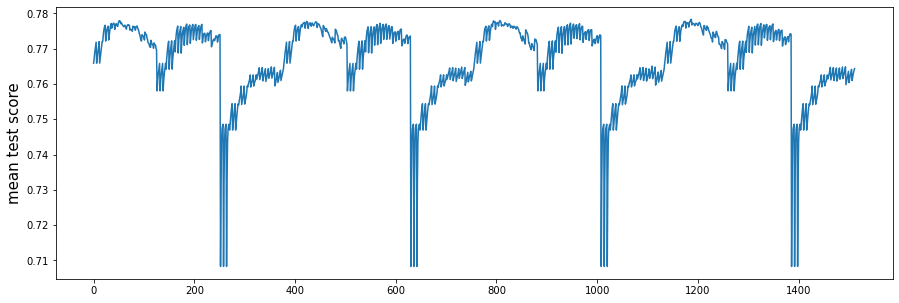

In [62]:
plt.figure(figsize=(15,5))
sns.lineplot(data=pd.DataFrame(grid_model.cv_results_)['mean_test_score'])
plt.ylabel('mean test score', fontsize=15);

Certain patterns were to be expected.

Finally, let's evaluate the obtained model.

In [ ]:
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve

In [11]:
print(classification_report(y_test, grid_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.96      0.89      4643
           1       0.71      0.35      0.47      1357

    accuracy                           0.82      6000
   macro avg       0.77      0.66      0.68      6000
weighted avg       0.81      0.82      0.80      6000



In [77]:
roc_auc_score(y_test, grid_model.predict_proba(X_test)[:, 1])

0.7806701350405703

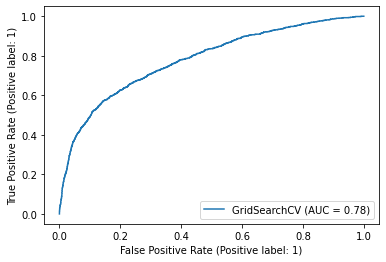

In [76]:
plot_roc_curve(grid_model, X_test, y_test);

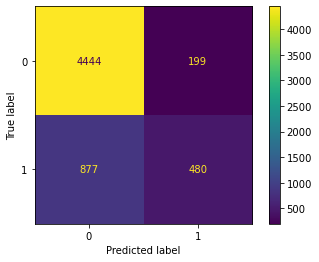

In [13]:
plot_confusion_matrix(grid_model, X_test, y_test);

## Interpreting Model with SHAP Values

In order to plot the SHAP values (impact on model output), we have to recreate the model as the shap library isn't yet compatible with GridSearchCV.

In [84]:
import shap

In [85]:
xgb = XGBClassifier(objective='binary:logistic', 
                    eval_metric='auc', 
                    n_jobs=-1, 
                    use_label_encoder=False,
                    gamma=1.5,
                    learning_rate=0.1,
                    max_depth=4,
                    min_child_weight=2,
                    n_estimators=100)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=1.5, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

Not we can plot the SHAP Values and find out what the most important features for our XGB model were.

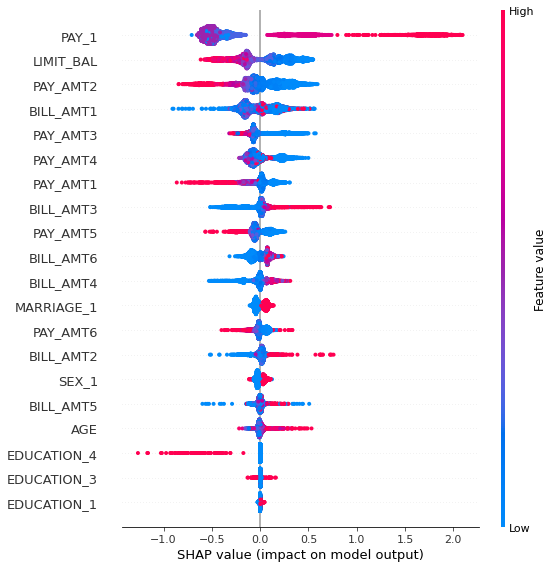

In [90]:
explainer = shap.explainers.Tree(xgb, data=X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values.values, X_test)

It seems that 'PAY_1' and 'LIMIT_BAL' were the most important features for our model. This makes completely sense since they were the most correlated features with the response variable, as we saw during the Data Analysis in the first part: if a person has defaulted once, it's likely they will do it again. And the lower the limit balance, the more likely they could default.

Let's also see what features interacted the most with 'PAY_1' and 'LIMIT_BAL'.

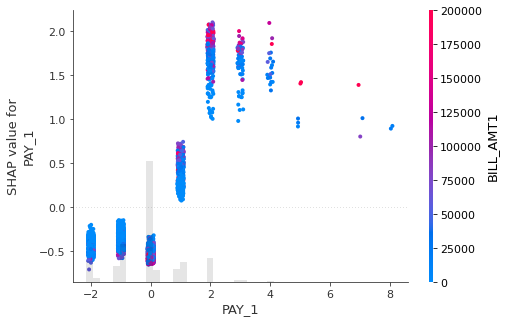

In [91]:
shap.plots.scatter(shap_values[:,'PAY_1'], color=shap_values)

The features that interacted the most with 'PAY_1' was 'BILL_AMT1'. In the previous scatterplot, the reddest colored dots tend to be upper and therefore the higher the risk of defaulting is.

Let's do the same for 'LIMIT_BAL'.

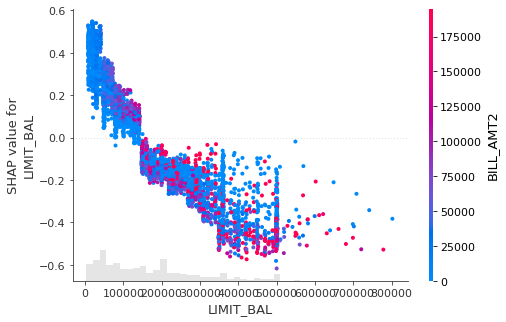

In [92]:
shap.plots.scatter(shap_values[:,'LIMIT_BAL'], color=shap_values)

It seems that the 'LIMIT_BAL' and 'BILL_AMNT2' interaction was quite important for our model too, the more the amount of bill statement the more likely an account owner with a low limit balance was to default.

## Financial Analysis

Finally, we'll take a look at what we can do with our model and how to benefit from it. First, let's plot histograms of the distribution of probabilities of defaulting per sample.

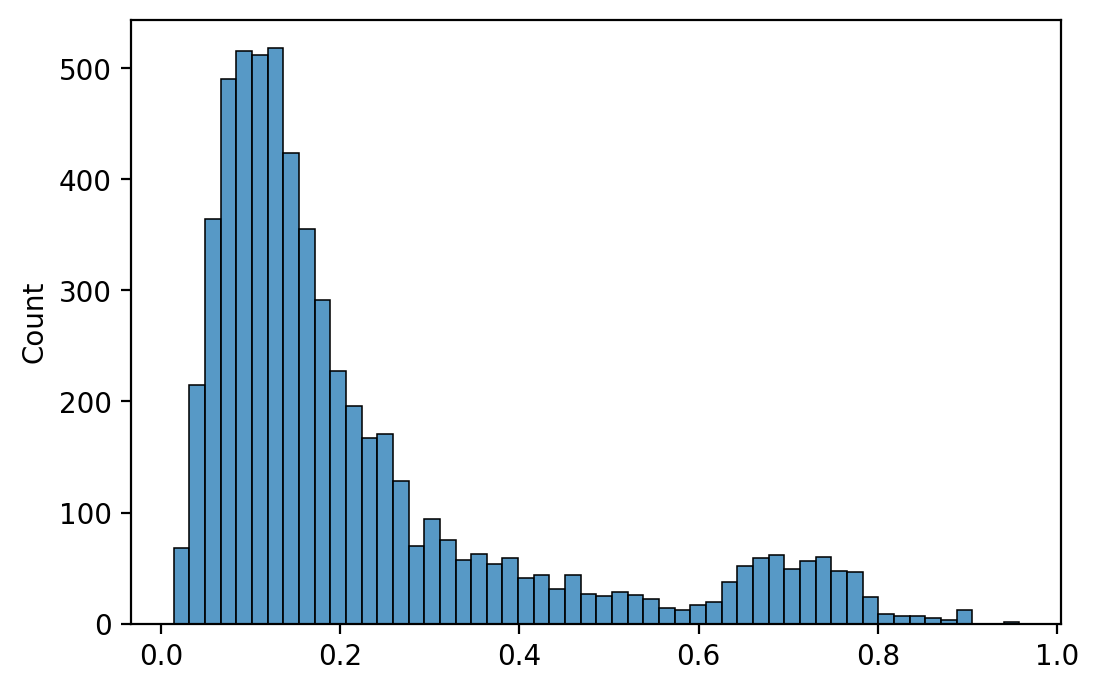

In [96]:
predictions_proba = xgb.predict_proba(X_test)[:,1]

plt.figure(dpi=200)
sns.histplot(data=predictions_proba);

As we already knew, most predictions fall within the range from 0 to 0.2. This was to be expected since most samples didn't default, and our model performs well especially for account owners who didn't default. On the other hand, most people who are likely to default fall within 0.6 and 0.8. 

Let's create decile charts to segment account owners. In other words, we will split the predicted probabilities for the test set into 10 bins.

In [97]:
deciles, decile_bin_edges = pd.qcut(x=predictions_proba, q=10, retbins=True)

Let's examine our bin edges.

In [98]:
decile_bin_edges

array([0.0144052 , 0.06473548, 0.08608369, 0.10687906, 0.12720212,
       0.15070676, 0.17868499, 0.22652783, 0.31025997, 0.55495645,
       0.9576298 ])

What we have done, is creating 10 equal sized bins, meaning that each bin will contain the exact same amount of samples as the other bins. For example, the birst bin is lower bounded by 0.0144052 and upper bounded by 0.06473548. This means that, according to our model, a 10% of the population of the test set has a probability of defaulting that falls between these lower and upper bounds, and so on with the rest of the bins. Every observation will belong to one and only one of these decile charts as the following dataframe shows.

In [99]:
test_set_df = pd.DataFrame({'Predicted prob. of defaulting':predictions_proba,
                            'Corresponding decile':deciles,
                            'True outcome':y_test})

test_set_df.head()

,Predicted prob. of defaulting,Corresponding decile,True outcome
25707,0.019915,"(0.013399999999999999, 0.0647]",0
2413,0.717296,"(0.555, 0.958]",1
13347,0.099833,"(0.0861, 0.107]",1
23686,0.132344,"(0.127, 0.151]",0
9944,0.092178,"(0.0861, 0.107]",0


For convenienve reasons, we will replace the decile with lots of decimal numbers with something shorter.

In [122]:
interval1 = test_set_df['Corresponding decile'].iloc[0]
interval2 = pd.Interval(left=0.0134, right=0.0647)

test_set_df['Corresponding decile'] = test_set_df['Corresponding decile'].replace({interval1 : interval2})

In [123]:
test_set_df.head()

,Predicted prob. of defaulting,Corresponding decile,True outcome
25707,0.019915,"(0.0134, 0.0647]",0
2413,0.717296,"(0.555, 0.958]",1
13347,0.099833,"(0.0861, 0.107]",1
23686,0.132344,"(0.127, 0.151]",0
9944,0.092178,"(0.0861, 0.107]",0


Since the 'Corresponding decile' is a discrete variable, and since we expect our model to have performed well, we can group the previous dataframe by the corresponding decile and calculate the mean of the true outcome for every decile. We should expect an increasing linear relationship between these.

In [124]:
# grouping by 'Corresponding decile'
groupby_test_df = test_set_df.groupby('Corresponding decile')

# calling summary stats and selecting 'True outcome'
groupby_test_df = groupby_test_df.describe()['True outcome']

# select only 'count' and 'mean'
groupby_test_df = groupby_test_df[['count', 'mean']]
groupby_test_df

,count,mean
Corresponding decile,,
"(0.0134, 0.0647]",600.0,0.041667
"(0.0647, 0.0861]",600.0,0.078333
"(0.0861, 0.107]",600.0,0.091667
"(0.107, 0.127]",600.0,0.131667
"(0.127, 0.151]",600.0,0.140000
"(0.151, 0.179]",600.0,0.163333
"(0.179, 0.227]",600.0,0.195000
"(0.227, 0.31]",600.0,0.251667
"(0.31, 0.555]",600.0,0.451667


Every decile consists of the same amount of observations. And we can also confirm that account owners in the last deciles, who have higher probabilty of defaulting according to our model, indeed are more leaned to default according to the mean of the true outcome.

Let's represent this information with a plot comparing the mean of defaulting per decile.

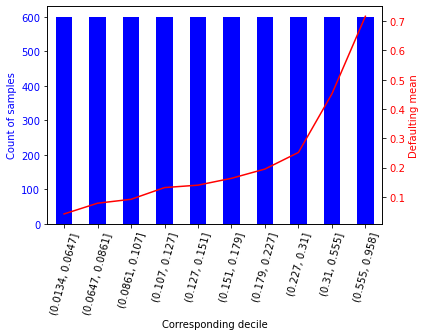

In [132]:
ax_1 = plt.axes()
groupby_test_df['count'].plot.bar(ax=ax_1, color='blue')
ax_1.set_ylabel('Count of samples', color='blue')
ax_1.tick_params(axis='y', labelcolor='blue')
ax_1.tick_params(axis='x', labelrotation = 75)

ax_2 = ax_1.twinx()
groupby_test_df['mean'].plot(ax=ax_2, color='red')
ax_2.set_ylabel('Defaulting mean', color='red')
ax_2.tick_params(axis='y', labelcolor='red')

Althouth the plot contains the same information as the previous dataframe, this is easier to understand. The defaulting mean per decile increases consistently, and remember the deciles were determined by our model. In other words, this is another way to confirm that our model has done it right.

The following question is to calculate the losses (in NT dollars) of the credit card company because of defaulting. To do this, we would actually need the bill statement of the next month per account, but unfortunately we don't have this information. Instead, we will use the bill statement of the previous month as our best estimator, this is 'BILL_AMT1'. First, let's compute the total of the 'BILL_AMT1' column:

In [139]:
print('Total of all of the bill statements of the month:'
      , X_test['BILL_AMT1'].sum())

Total of all of the bill statements of the month: 309730868


Now, let's compute the losses, this is, the total losses because of people who failed to pay the bill statement of the month:

In [142]:
print('Losses because of people did not make the payment of the month:'
      , X_test[y_test.astype(bool)]['BILL_AMT1'].sum() )

Losses because of people did not make the payment of the month: 68784686


The total losses for the credit card company goes around 68,784,686 NT dollars. 

Next is to make a decision about how to revert the previous number. To do this, let's suppose that the company will use our model to predict which account owners will default and so they can prevent this by hiring a counselor who will contact these account owners and try to come to an acceptable agreement. Given the results of our model, the company needs to know which account owners are to be contacted. Obviously, those at higher probability (according to the model) have priority, but what exactly will be this probability? To figure this out, we will try all of the possible thresholds from 0 to 1, and calculate the savings supposing that the counselor has a 70% of efectiveness and a cost of 8,000 NT dollars for his/her services for each account owner that is contacted.

In [146]:
# setting up the thresholds from 0 to 1 (for all the probabilities) 
thresholds = np.linspace(0, 1, 101)

# cost per person contacted
cost_service = 8000
# efectiveness at coming to an agreement to pay
effectiveness = 0.7

# placeholders
n_pos_predictions = np.empty_like(thresholds)
total_cost = np.empty_like(thresholds)
n_true_pos_predictions = np.empty_like(thresholds)
total_savings = np.empty_like(thresholds)

In [149]:
counter = 0

for threshold in thresholds:
    
    # account owners to be contacted
    pos_predictions = (predictions_proba > threshold)
    n_pos_predictions[counter] = sum(pos_predictions)
    
    # from people contacted, those who would default
    true_pos = (pos_predictions & y_test.astype(bool))
    n_true_pos_predictions[counter] = sum(true_pos)
    
    # total cost per services
    total_cost[counter] = n_pos_predictions[counter] * cost_service
    
    # computing 70% of the total 'BILL_AMT1' by the threshold
    total_savings[counter] = np.sum(true_pos.astype(int) * X_test['BILL_AMT1']
                            * effectiveness)
    counter += 1

In [150]:
savings = total_savings - total_cost

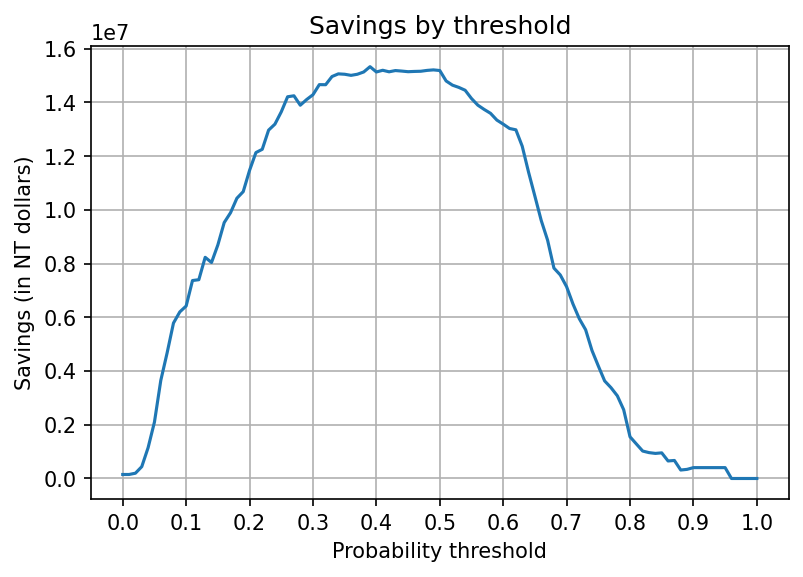

In [160]:
plt.figure(dpi=150)
plt.plot(thresholds, savings)
plt.title('Savings by threshold')
plt.xlabel('Probability threshold')
plt.ylabel('Savings (in NT dollars)')
plt.xticks(np.linspace(0,1,11))
plt.grid(True)

In [163]:
max_savings_index = np.argmax(savings)
thresholds[max_savings_index]

0.39

In [170]:
round(savings[max_savings_index],2)

15333317.4

Therefore, we conclude that the peak of savings ocurr when we contact those who have a higher probability than 0.39 of defaulting. The amount of savings in NT dollars is roughly 15,000,000.

## Final Comments

- While at the end we have come with an acceptable amount of savings thanks to our model, it should be adressed that this model could easily be improved with more data, as well as the correct features for PAY_2, ..., PAY_6 that we had to drop because of their unreliability. Still, the model has performed pretty decently.

- On ther other hand, we didn't have the true bill statement for the next month, and so we had to use the previous bill statement as an estimator. Of course, this also could be easily corrected with access to more data from the company.

- On the same line, in a real life situation we should probably take into account several counselors and different outcomes for their services (surely, they can't all have the same performance), so more variables would have to be taken into account, however this could easily be solved and implemented.

## Thanks for reading.